In [2]:
from VIPurPCAvsMC import *
import jax.numpy as np
import jax
from jax import jacrev, vmap
from sklearn.decomposition import PCA
from utils import MidpointNormalize
import seaborn as sns
import time

In [ ]:
true = np.array([[-1, -2],[-3, -4]])
test = np.array([[[1, 2],[3, 4]],
                 [[-1, -2],[-3,-4]]])

In [ ]:
np.allclose(vmap(outer_function_correcting, (0, None), 0)(test, true), np.array([[[-1, -2],[-3, -4]],
                 [[-1, -2],[-3,-4]]]))

In [ ]:
def wasserstein_distance(m1, m2, c1, c2):
    return (np.sum((m1-m2)**2) + np.trace(c1 + c2 - 2 * (c1**0.5 @ c2 @ c1**0.5)**0.5))

In [2]:
def plot_heatmap(X, ax=None):
    return sns.heatmap(X, cmap='bwr', 
               norm=MidpointNormalize(midpoint=0, vmin=np.min(np.array([X])), vmax=np.max(np.array([X]))), ax=ax)

In [3]:
#def compute_error(m_vipurpca, m_mc, c_vipurpca, Vs, ind):
#    where = np.zeros_like(Vs)
#    where = where.at[:, :ind].set(1)
#    Vs = Vs - np.mean(Vs, axis=0, where=where)
#    Vs = Vs.at[:, ind:].set(0)
#    c_mc = 1/(ind-1)*(np.dot(Vs, np.transpose(Vs)))
#    return wasserstein_distance(m_vipurpca, m_mc, c_vipurpca, c_mc)

In [4]:
def frobenius_norm(X):
    return np.sqrt(np.sum(X**2))

In [5]:
def l2_norm(X):
    return np.linalg.norm(X, ord=2)

In [17]:
def rmsd(X, Y):
    return np.sqrt(np.trace(np.dot(np.transpose(X-Y), (X-Y)))/(X.shape[0]*X.shape[1]))

In [7]:
def expectation_maximization(Y, n, p, p_keep, n_samples):
    M = np.mean(Y, axis=0)
    print(M.shape)
    Y = Y - M
    V_0 = np.identity(p)
    U_0 = np.identity(min(n, p, p_keep))
    U_prev = U_0
    V_prev = V_0
    for i in range(1000):
        U_curr = 1/(n_samples*p)*np.sum(vmap(lambda y: np.dot(np.dot(y, np.linalg.inv(V_prev)), y.T))(Y), axis=0)
        V_curr = 1/(n_samples*n)*np.sum(vmap(lambda y: np.dot(np.dot(y.T, np.linalg.inv(U_prev)), y))(Y), axis=0)
        U_curr = U_curr/np.linalg.norm(U_curr, 2)
        V_curr = np.linalg.norm(U_curr, 2)*V_curr
        U_prev = U_curr
        V_prev = V_curr
        if i%100==0:
            print(V_prev)
    return U_curr, V_curr

In [8]:
def compute_error_expectation_maximization(C_vipurpca, mean_vipurpca, Vs, n, p, p_keep, n_samples, ind):
    where = np.zeros_like(Vs)
    where = where.at[:ind, :].set(1)
    Vs_mean = np.mean(Vs, axis=0, where=where)
    Vs = Vs - Vs_mean
    Vs = Vs.at[ind:, :].set(0)
    Vs = vmap(lambda x: np.transpose(np.reshape(x, (min(n, p_keep), p), 'C')))(Vs)
    U, V = expectation_maximization(Vs, n, p, p_keep, n_iter)
    #C_mc = npv.kron(V, U)
    return U, V

In [24]:
def compute_error(C_vipurpca, mean_vipurpca, Vs, ind):
    where = np.zeros_like(Vs)
    where = where.at[:ind, :].set(1)
    Vs_mean = np.mean(Vs, axis=0, where=where)
    Vs = Vs - Vs_mean
    Vs = Vs.at[ind:, :].set(0)
    C_mc = 1/(ind-1)*(np.dot(np.transpose(Vs), Vs))
    #error_cov = rmsd(C_vipurpca, C_mc)
    #error_mean = l2_norm(Vs_mean - mean_vipurpca)/l2_norm(mean_vipurpca)
    error_cov = frobenius_norm(C_mc - C_vipurpca)/frobenius_norm(C_vipurpca)
    error_mean = frobenius_norm(Vs_mean - mean_vipurpca)/frobenius_norm(mean_vipurpca)
    return error_cov, error_mean

In [1]:
n, p, p_keep = (10000, 1000, 2)
A, B, X_flat, X_unflattener, y = generate_data(n, p)
centered_mean = X_unflattener(X_flat) - np.mean(X_unflattener(X_flat), axis=0)

NameError: name 'generate_data' is not defined

In [ ]:
n_iter = 1000
# normal PCA
print('Start PCA')
V = pca(X_flat, X_unflattener, p_keep)
#T = centered_mean @ np.transpose(np.reshape(V, (min(n, p_keep), p), 'C'))
print('Start VIPurPCA')
start = time.time()
# VIPurPCA
f = lambda X: pca(X, X_unflattener, p_keep)
_, f_vjp = vjp(f, X_flat)
_, f_jvp = jax.linearize(f, X_flat)
cvp_fun = lambda s: cvp(f_jvp, f_vjp, X_flat, X_unflattener, A, B, n, p, p_keep, s)
#C = np.array([cvp_fun(i) for i in range(min(n, p_keep)*p)])
#C = map(cvp_fun, np.arange(min(n, p_keep)*p))
#C = map(cvp_fun, np.arange(1))
batch_size = 1000
b = batch(np.arange(min(n, p_keep)*p), batch_size)
C = np.vstack([vmap(cvp_fun)(i) for i in b])
#C = vmap(cvp_fun)(np.arange(min(n, p_keep)*p))
end = time.time()
#np.save(arr=C, file=os.path.join(path, 'C_VIPurPCA'))
print('vipurpca-time: ', end-start) 
start = time.time()
# Monte-Carlo
batch_size=1000
Vs = MC(X_flat, X_unflattener, A, B, p_keep, n_iter, batch_size)
Vs = vmap(outer_function_correcting, (0, None), 0)(Vs, np.reshape(V, (min(n, p_keep), p), 'C'))
Vs = vmap(lambda x: np.ravel(x, 'C'))(Vs)
C_mc = np.cov(np.transpose(Vs))
end = time.time()
print('mc-time: ', end-start)

Start PCA
Start VIPurPCA


In [12]:
n_iter = 10000
V = pca(X_flat, X_unflattener, p_keep)
# VIPurPCA
f = lambda X: pca(X, X_unflattener, p_keep)
_, f_vjp = vjp(f, X_flat)
_, f_jvp = jax.linearize(f, X_flat)
cvp_fun = lambda s: cvp(f_jvp, f_vjp, X_flat, X_unflattener, A, B, n, p, p_keep, s)
C = np.array([cvp_fun(i) for i in range(min(n, p_keep)*p)])
key = jax.random.PRNGKey(42)
V_drawn = jax.random.multivariate_normal(key, V, C+1e-6*np.eye(V.shape[0]), shape=(n_iter,))
T_s = np.array([centered_mean @ np.transpose(np.reshape(i, (p_keep, p), 'C')) for i in V_drawn])
## Monte-Carlo
Vs, s = MC(X_flat, X_unflattener, A, B, p_keep, n_iter)
#plt.imshow(vmap(lambda x: np.ravel(x, 'C'))(Vs))
Vs = vmap(outer_function_correcting, (0, None), 0)(Vs, np.reshape(V, (min(n, p_keep), p), 'C'))
#centered_s = vmap(lambda x: np.reshape(x, (n, p), 'F')-np.mean(np.reshape(x, (n, p), 'F'), axis=0))(s)
s = vmap(lambda x: np.reshape(x, (n, p), 'F'))(s)
T_mcs = np.array([j @ np.transpose(i) for i, j in zip(Vs, s)])
T_mcs = np.array([centered_mean @ np.transpose(i) for i in Vs])
Vs = vmap(lambda x: np.ravel(x, 'C'))(Vs)
C_mc = np.cov(np.transpose(Vs))

In [37]:
r = [int(i) for i in np.logspace(1, np.log2(n_iter), num=20, base=2)]
errors = np.array([compute_error(C, V, Vs, int(i)) for i in np.logspace(1, np.log2(n_iter), num=20, base=2)])
#U, V = compute_error(C, V, Vs, n, p, p_keep, n_iter, int(n_iter))


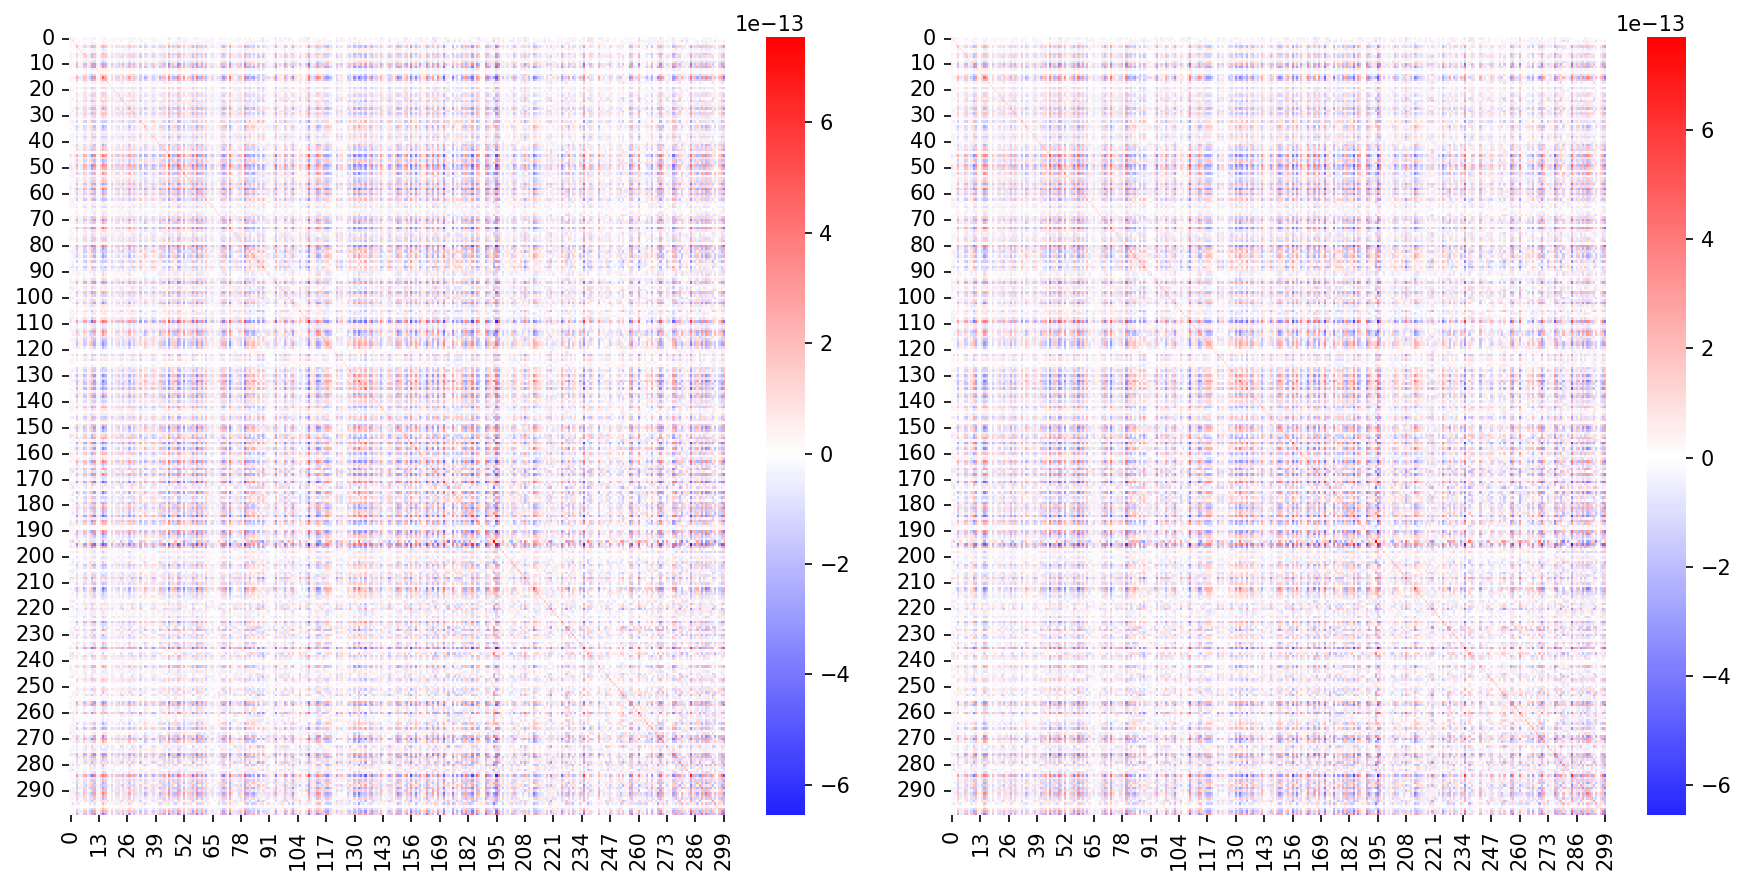

In [36]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
#sns.heatmap(C_mc, cmap='bwr', 
#           norm=MidpointNormalize(midpoint=0, vmin=np.min(np.array([C_mc, C])), vmax=np.max(np.array([C_mc, C]))), ax=ax1)
#sns.heatmap(C, cmap='bwr', 
#            norm=MidpointNormalize(midpoint=0, vmin=np.min(np.array([C_mc, C])), vmax=np.max(np.array([C_mc, C]))), ax=ax2)
plot_heatmap(C_mc[200:500, 200:500], ax1)
plot_heatmap(C[200:500, 200:500], ax2)
#sns.heatmap(C_samples, cmap='bwr', 
#            norm=MidpointNormalize(midpoint=0, vmin=np.min(np.array([C_samples])), vmax=np.max(np.array([C_samples]))), ax=ax3)
plt.tight_layout()

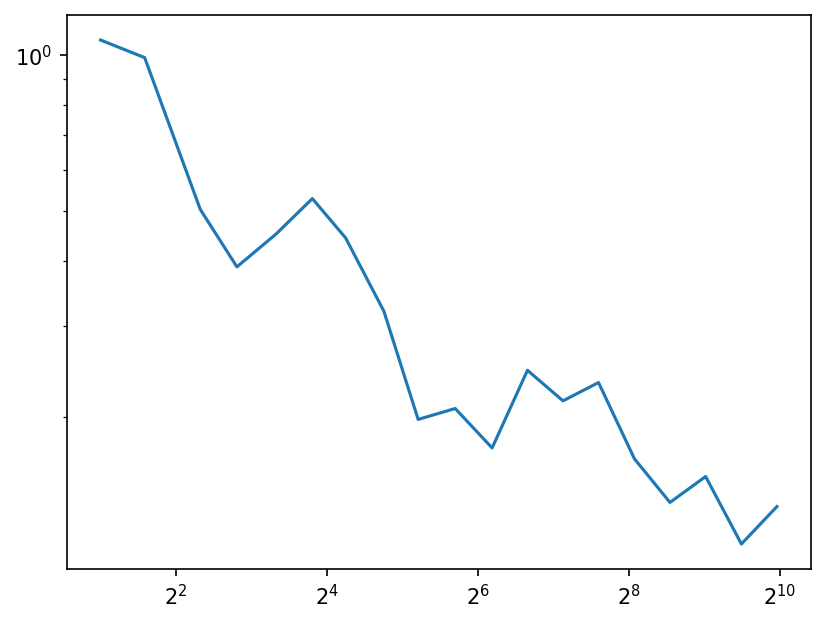

In [38]:
plt.plot(r, errors[:, 0])
#plt.plot(r, errors[:, 1])
plt.yscale('log', base=10)
plt.xscale('log', base=2)

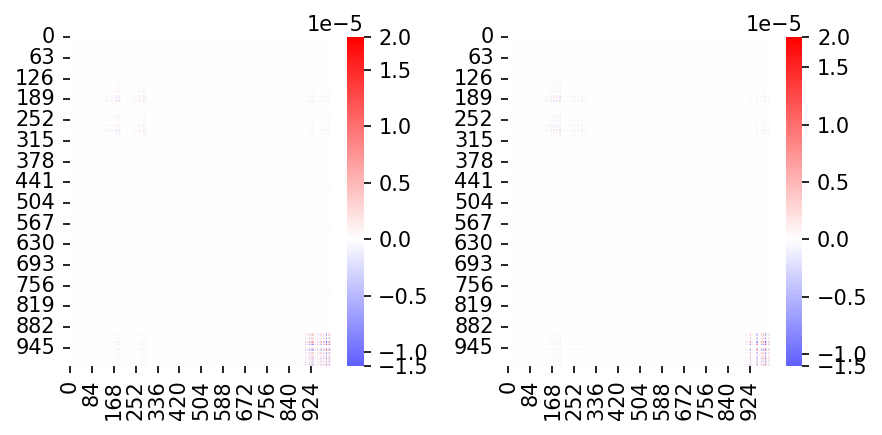

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
#sns.heatmap(C_mc, cmap='bwr', 
#           norm=MidpointNormalize(midpoint=0, vmin=np.min(np.array([C_mc, C])), vmax=np.max(np.array([C_mc, C]))), ax=ax1)
#sns.heatmap(C, cmap='bwr', 
#            norm=MidpointNormalize(midpoint=0, vmin=np.min(np.array([C_mc, C])), vmax=np.max(np.array([C_mc, C]))), ax=ax2)
sns.heatmap(C_mc, cmap='bwr', 
            norm=MidpointNormalize(midpoint=0, vmin=np.min(np.array([C_mc])), vmax=np.max(np.array([C_mc]))), ax=ax1)
sns.heatmap(C, cmap='bwr', 
            norm=MidpointNormalize(midpoint=0, vmin=np.min(np.array([C])), vmax=np.max(np.array([C]))), ax=ax2)
plt.tight_layout()

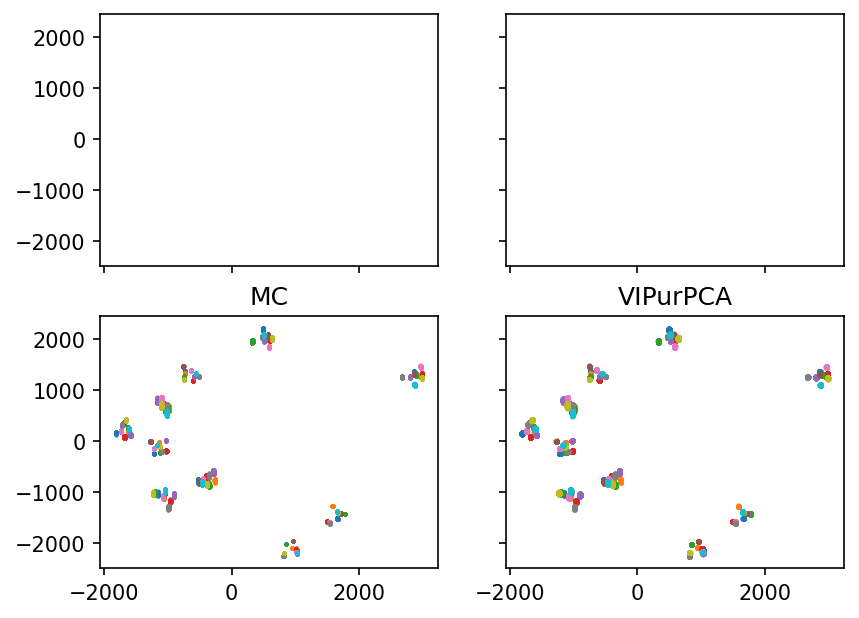

In [17]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True)
pcx, pcy = (0, 1)
for j in range(n):
    #sns.kdeplot(x=T_mcs[:, j, pcx], y=T_mcs[:, j, pcy], shade=True, ax=ax1)
    #ax1.set_title('kde MC')
    #sns.kdeplot(x=T_s[:, j, pcx], y=T_s[:, j, pcy], shade=True, ax=ax2)
    #ax2.set_title('kde VIPurPCA')
    ax3.scatter(x=T_mcs[:, j, pcx], y=T_mcs[:, j, pcy], s=1)
    ax3.set_title('MC')
    ax4.scatter(x=T_s[:, j, pcx], y=T_s[:, j, pcy], s=1)
    ax4.set_title('VIPurPCA')

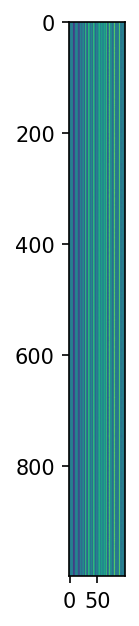

In [15]:
plt.imshow(Vs)

<AxesSubplot:>

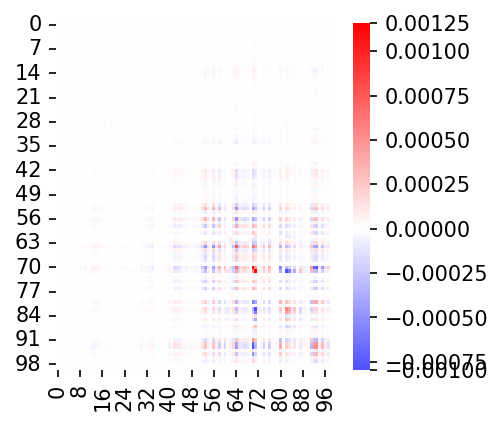

In [22]:
J = jacrev(lambda X: pca(X, X_unflattener, p_keep))(X_flat)
C_jacrev = J @ np.kron(A, B) @ J.T
f, ax = plt.subplots(figsize=(3, 3))
sns.heatmap(C_jacrev, cmap='bwr', 
            norm=MidpointNormalize(midpoint=0, vmin=np.min(np.array([C_jacrev])), vmax=np.max(np.array([C_jacrev]))), ax=ax)

In [24]:
print(J.shape, np.kron(A, B).shape)

(100, 1000) (1000, 1000)


In [ ]:
n, p, p_keep = (100, 100, 2)
A, B, X_flat, X_unflattener, y = generate_data(n, p)
centered_mean = X_unflattener(X_flat) - np.mean(X_unflattener(X_flat), axis=0)
# normal PCA
V = pca(X_flat, X_unflattener, p_keep)
#T = centered_mean @ np.transpose(np.reshape(V, (min(n, p_keep), p), 'C'))
#plt.scatter(T[:, 0], T[:, 1], c = y)
# sklearn PCA
#pca_sklearn = PCA()
#T_sklearn = pca_sklearn.fit_transform(X_unflattener(X_flat))
#plt.scatter(T_sklearn[:, 0], T_sklearn[:, 1], c = y)

print('start pca')
start = time.time()
# VIPurPCA
f = lambda X: pca(X, X_unflattener, p_keep)
_, f_vjp = vjp(f, X_flat)
_, f_jvp = jax.linearize(f, X_flat)
cvp_fun = lambda s: cvp(f_jvp, f_vjp, X_flat, X_unflattener, A, B, n, p, p_keep, s)
C = np.array([cvp_fun(i) for i in range(min(n, p_keep)*p)])
#C = vmap(lambda s: cvp(f_jvp, f_vjp, X_flat, X_unflattener, A, B, n, p, p_keep, s))(np.arange(min(n, p_keep)*p))
#C = np.array([cvp_fun(i) for i in range(min(n, p_keep)*p)])
#key = jax.random.PRNGKey(42)
#V_drawn = jax.random.multivariate_normal(key, V, C+1e-6*np.eye(V.shape[0]), shape=(1000,))
#T_s = np.array([centered_mean @ np.transpose(np.reshape(i, (p_keep, p), 'C')) for i in V_drawn])
end = time.time()
print(end-start)

#start = time.time()
## Monte-Carlo
Vs, s = MC(X_flat, X_unflattener, A, B, p_keep, 1024)
Vs = vmap(outer_function_correcting, (0, None), 0)(Vs, np.reshape(V, (min(n, p_keep), p), 'C'))
##centered_s = vmap(lambda x: np.reshape(x, (n, p), 'F')-np.mean(np.reshape(x, (n, p), 'F'), axis=0))(s)
##T_mcs = np.array([j @ np.transpose(i) for i, j in zip(Vs, centered_s)])
##T_mcs = np.array([centered_mean @ np.transpose(i) for i in Vs])
Vs = vmap(lambda x: np.ravel(x, 'C'))(Vs)
C_mc = np.cov(np.transpose(Vs))
##mean_mc = np.mean(Vs, axis=0)
##key = jax.random.PRNGKey(42)
##V_drawn = jax.random.multivariate_normal(key, mean_mc, C_mc+1e-6*np.eye(V.shape[0]), shape=(100,))
#end = time.time()
#print(end-start)

#start = time.time()
## VIPurPCA
#f = lambda X: pca(X, X_unflattener, p_keep)
#_, f_vjp = vjp(f, X_flat)
#_, f_jvp = jax.linearize(f, X_flat)##
#
#cvp_fun = lambda s: cvp(f_jvp, f_vjp, X_flat, X_unflattener, A, B, n, p, p_keep, s)
#C = np.array([cvp_fun(i) for i in range(min(n, p_keep)*p)])
##key = jax.random.PRNGKey(42)
##V_drawn = jax.random.multivariate_normal(key, V, C+1e-6*np.eye(V.shape[0]), shape=(1000,))
##T_s = np.array([centered_mean @ np.transpose(np.reshape(i, (p_keep, p), 'C')) for i in V_drawn])
#end = time.time()
#print(end-start)

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
sns.heatmap(C_mc, cmap='bwr', 
            norm=MidpointNormalize(midpoint=0, vmin=np.min(np.array([C_mc, C])), vmax=np.max(np.array([C_mc, C]))), ax=ax1)
sns.heatmap(C, cmap='bwr', 
            norm=MidpointNormalize(midpoint=0, vmin=np.min(np.array([C_mc, C])), vmax=np.max(np.array([C_mc, C]))), ax=ax2)
plt.tight_layout()

In [ ]:
r = range(2, 1000, 20)
errors2 = [compute_error(C, np.transpose(Vs), i) for i in r]

In [ ]:
f = plt.figure(tight_layout = {'pad': 0.1})
plt.ylabel('Error')
plt.xlabel('Monte Carlo iterations')
#plt.plot([i for i in r], errors, 'o-')
plt.plot([i for i in r], errors2, 'o-')
#plt.yscale('log', base=10)
#plt.xscale('log', base=10)
plt.tight_layout()

In [ ]:
Vs = vmap(lambda x: np.ravel(x, 'C'))(Vs)
C_mc = np.cov(np.transpose(Vs))

In [ ]:
def pca(X_flat, n, p, p_keep):
    X = np.reshape(X_flat, (n, p), 'F')
    X = X - np.mean(X, axis=0)
    _, _, V = np.linalg.svd(X, full_matrices=False)
    return flatten_util.ravel_pytree(V[0:p_keep, :])[0]
f = lambda X: pca(X, n, p, p_keep)
J = jacrev(f)(np.ravel(X_unflattener(X_flat), 'F'))

In [ ]:
C_jacrev = J @ (np.kron(B, A)) @ J.T

In [ ]:
f = plt.figure(figsize=(2, 2))
sns.heatmap(C_jacrev, cmap='bwr', 
            norm=MidpointNormalize(midpoint=0, vmin=np.min(C_jacrev), vmax=np.max(C_jacrev)))

In [ ]:
key = jax.random.PRNGKey(42)
V_drawn = jax.random.multivariate_normal(key, V, C_mc+1e-6*np.eye(V.shape[0]), shape=(100,))

In [ ]:
T_test = np.array([centered_mean @ np.transpose(np.reshape(i, (p_keep, p), 'C')) for i in V_drawn])

In [ ]:
f, ax = plt.subplots()
for j in range(n):
    plt.scatter(x=T_test[:, j, 3], y=T_test[:, j, 4])
plt.scatter(T[:, 3], T[:, 4], c='black')

In [ ]:
n, p, p_keep = (1000, 100, 2)
n_iter = 1000
A, B, X_flat, X_unflattener, y = generate_data(n, p)
start = time.time()
s1 = scipy.stats.matrix_normal.rvs(X_unflattener(X_flat), rowcov=A, colcov=B, size=n_iter)
end = time.time()
print(end-start)

In [203]:
def draw_samples(key, X_flat, X_unflattener, A, B, n, p):
    x = jax.random.multivariate_normal(key, np.zeros(p), np.identity(p), (n, ))
    return  X_unflattener(X_flat) + np.dot(np.dot(np.linalg.cholesky(A), x), np.linalg.cholesky(B))
start = time.time()
key = jax.random.PRNGKey(42)
subkeys = jax.random.split(key, n_iter)
s2 = np.array([draw_samples(i, X_flat, X_unflattener, A, B, n, p) for i in subkeys])
end = time.time()
print(end-start)

TypeError: cholesky() got an unexpected keyword argument 'lower'

In [53]:
def draw_samples(key, X_flat, X_unflattener, A, B, n, p, n_iter):
    x = jax.random.normal(key, (p, n_iter, n))
    roll_rvs = np.tensordot(np.linalg.cholesky(B), np.dot(x, np.linalg.cholesky(A).T), 1)
    return  np.moveaxis(roll_rvs.T, 1, 0) + X_unflattener(X_flat)[np.newaxis, :, :]

In [54]:
n, p, p_keep = (100, 11, 11)
A, B, X_flat, X_unflattener, y = generate_data(n, p)
n_iter = 10000
key = jax.random.PRNGKey(42)
subkeys = jax.random.split(key, n_iter)
s = draw_samples(key, X_flat, X_unflattener, A, B, n, p, n_iter)
print(s.shape)
s_flat = vmap(lambda x: np.ravel(x, 'F'))(s)

(10000, 100, 11)


In [55]:
samples_cov = np.cov(np.transpose(s_flat))

In [56]:
s = scipy.stats.matrix_normal.rvs(mean=X_unflattener(X_flat), rowcov=A, colcov=B, size=n_iter)
s_flat = vmap(lambda x: np.ravel(x, 'F'))(s)
samples_cov2 = np.cov(np.transpose(s_flat))

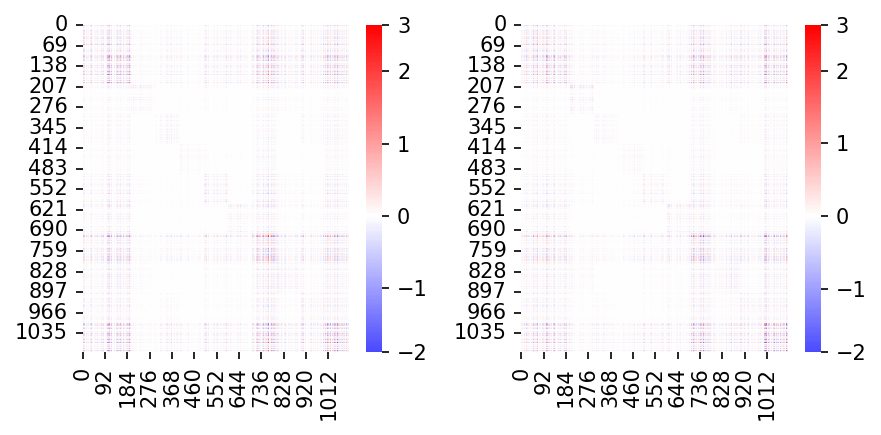

In [57]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
sns.heatmap(samples_cov, cmap='bwr', 
            norm=MidpointNormalize(midpoint=0, vmin=np.min(np.array([samples_cov])), vmax=np.max(np.array([samples_cov]))), ax=ax1)
sns.heatmap(samples_cov2, cmap='bwr', 
            norm=MidpointNormalize(midpoint=0, vmin=np.min(np.array([samples_cov2])), vmax=np.max(np.array([samples_cov2]))), ax=ax2)
plt.tight_layout()

In [207]:
def expectation_maximization(Y, n, p, n_samples):
    M = np.mean(Y, axis=0)
    print(M.shape)
    Y = Y - M
    V_0 = np.identity(p)
    U_0 = np.identity(n)
    U_prev = U_0
    V_prev = V_0
    for i in range(1000):
        U_curr = 1/(n_samples*p)*np.sum(vmap(lambda y: np.dot(np.dot(y, np.linalg.inv(V_prev)), y.T))(Y), axis=0)
        V_curr = 1/(n_samples*n)*np.sum(vmap(lambda y: np.dot(np.dot(y.T, np.linalg.inv(U_prev)), y))(Y), axis=0)
        U_curr = U_curr/np.linalg.norm(U_curr, 2)
        V_curr = np.linalg.norm(U_curr, 2)*V_curr
        U_prev = U_curr
        V_prev = V_curr
    return U_curr, V_curr

In [208]:
U, V = expectation_maximization(s, n, p, n_iter)
U=U*100
V=V/100

(100, 11)


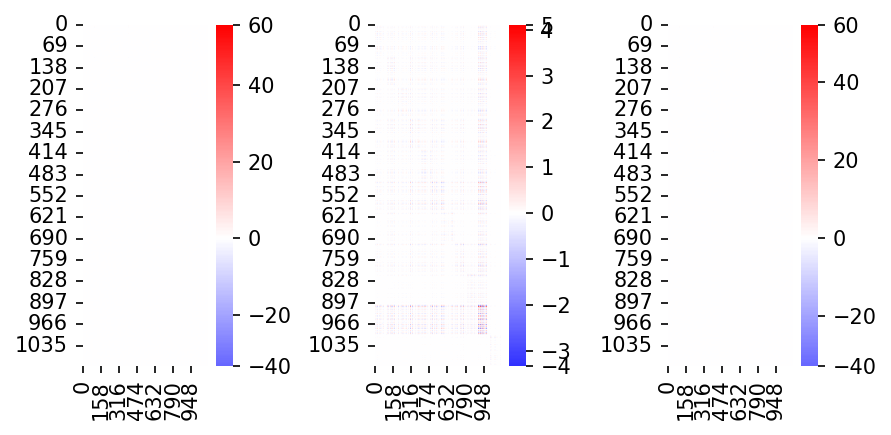

In [209]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 3))
sns.heatmap(samples_cov, cmap='bwr', 
            norm=MidpointNormalize(midpoint=0, vmin=np.min(np.array([samples_cov])), vmax=np.max(np.array([samples_cov]))), ax=ax1)
sns.heatmap(np.kron(B, A), cmap='bwr', 
            norm=MidpointNormalize(midpoint=0, vmin=np.min(np.array([np.kron(B, A)])), vmax=np.max(np.array([np.kron(B, A)]))), ax=ax2)
sns.heatmap(np.kron(V, U), cmap='bwr', 
            norm=MidpointNormalize(midpoint=0, vmin=np.min(np.array([np.kron(V, U)])), vmax=np.max(np.array([np.kron(V, U)]))), ax=ax3)
plt.tight_layout()

In [200]:
print(np.kron(B, A))

[[ 0.09763609  0.05125833  0.04248803 ... -0.0041414   0.05115616
  -0.02521394]
 [ 0.05125833  0.04423659  0.02512113 ... -0.00345379  0.03163135
  -0.01559862]
 [ 0.04248803  0.02512113  0.03030092 ... -0.00256     0.02521894
  -0.0115648 ]
 ...
 [-0.0041414  -0.00345379 -0.00256    ...  0.05980811 -0.03441048
   0.01714422]
 [ 0.05115616  0.03163135  0.02521894 ... -0.03441048  0.36692774
  -0.15100342]
 [-0.02521394 -0.01559862 -0.0115648  ...  0.01714422 -0.15100342
   0.13828646]]


In [201]:
print(samples_cov)

[[ 0.75981104  0.4036085   0.3361304  ... -0.00784948  0.04562465
  -0.0225472 ]
 [ 0.4036085   0.34991837  0.19952598 ... -0.00651696  0.02883538
  -0.01534831]
 [ 0.3361304   0.19952598  0.24478307 ... -0.00485902  0.0228704
  -0.0107378 ]
 ...
 [-0.00784948 -0.00651696 -0.00485902 ...  0.01167868 -0.00704392
   0.00322687]
 [ 0.04562465  0.02883538  0.0228704  ... -0.00704392  0.0728006
  -0.03083737]
 [-0.0225472  -0.01534831 -0.0107378  ...  0.00322687 -0.03083737
   0.02714444]]


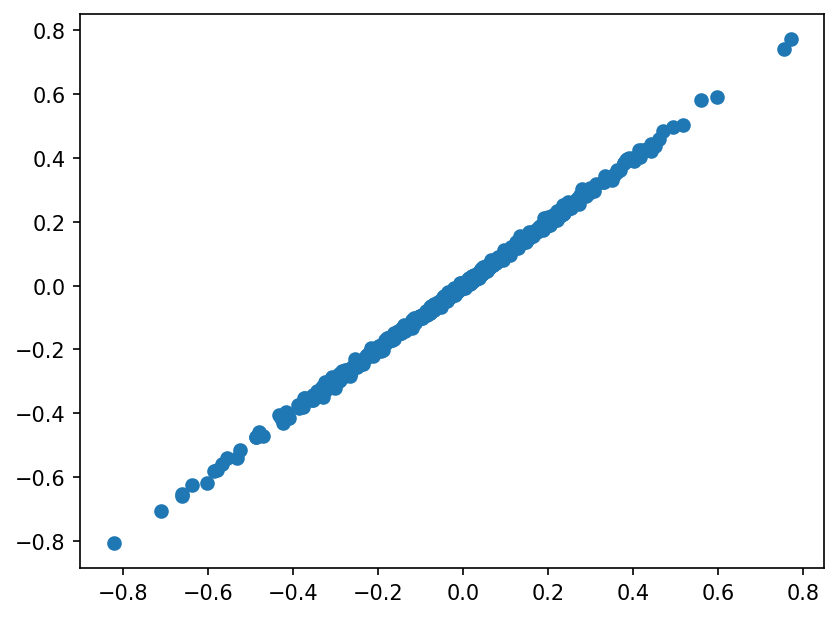

In [202]:
plt.scatter(np.kron(V, U)[1], samples_cov[1])

In [193]:
frobenius_norm(np.kron(B, A)-np.kron(V, U))/frobenius_norm(np.kron(B, A))

DeviceArray(0.02597247, dtype=float32)

In [194]:
frobenius_norm(np.kron(B, A)-samples_cov)/frobenius_norm(np.kron(B, A))

DeviceArray(0.06938665, dtype=float32)

In [45]:
print(C[157], C_mc[157])

[ 6.3224098e-07  3.0827734e-05  1.7316686e-05 ... -2.6130404e-06
 -1.2077779e-05  1.3190117e-05] [ 1.5857053e-06  3.5749465e-05  3.0337116e-05 ... -1.5603273e-06
 -1.3750465e-05  1.6787224e-05]
